# Tugas Besar II2111 Probabilitas dan Statistika

Ceavin Rufus De Prayer Purba  
18221162

In [155]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from textwrap import wrap
from scipy.stats import norm
import scipy.stats as st
import math
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.api as sm

#### Setup

In [156]:
mpl.rcParams['text.color'] = 'black'
mpl.rcParams['axes.labelcolor'] = 'black'
mpl.rcParams['axes.titlecolor'] = 'black'
mpl.rcParams['legend.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'


#### Color Palettes

In [157]:
listPalette = ["Blues", "Accent"]

def palette(no, num_of_color, reversed=True):
    if reversed:
        return sns.color_palette(listPalette[no-1]+'_r', num_of_color).as_hex()
    else:
        return sns.color_palette(listPalette[no-1], num_of_color).as_hex()

##### Read 18221162.xlsx

In [158]:
df = pd.read_excel('18221162.xlsx')

#### Data Cleansing

In [159]:
# Membersihkan data kotor pada kolom usia
df_clean = df.copy()

## Mengganti data null pada kolom usia dengan rata-rata usia orang yang memiliki pekerjaan yang sama
df_clean.loc[(pd.isnull(df_clean['Usia'])) & (df_clean['Pekerjaan'] == 'Pengusaha'), 'Usia'] = int(df_clean.loc[(df_clean['Pekerjaan'] == 'Pengusaha'), 'Usia'].mean())
df_clean.loc[(pd.isnull(df_clean['Usia'])) & (df_clean['Pekerjaan'] == 'Profesional ( Dokter, Dosen, Pengacara, dll)'), 'Usia'] = int(df_clean.loc[(df_clean['Pekerjaan'] == 'Pelajar / Mahasiswa'), 'Usia'].mean())

## Asumsi: Responden salah mengisi usia dengan tahun lahir
## Mengganti data tidak masuk akal pada kolom Usia diganti dengan usia responden pada tahun 2022 (tahun survei diadakan)
df_clean.loc[df_clean['Usia'] > 100, 'Usia'] = 2022 - df.loc[df['Usia'] > 100]['Usia']

## Asumsi pekerjaan orang yang tidak mengisi data pekerjaan merupakan seorang Ibu Rumah Tangga (karena usianya > 40 dan jenis kelamin wanita)
df_clean.loc[(pd.isnull(df['Pekerjaan'])) & (df_clean['Usia'] > 40) & (df_clean['Jenis Kelamin'] == 'Wanita'), 'Pekerjaan'] = 'Ibu Rumah Tangga'

## Mengganti data double (hanya berbeda lettercase/bahasa)
df_clean.loc[(df_clean['Pekerjaan'] == 'pegawai bumn'), 'Pekerjaan'] = 'Pegawai BUMN'
df_clean.loc[(df_clean['Pekerjaan'] == 'Butuh harian lepas'), 'Pekerjaan'] = 'Freelancer'

## Mengganti data yang bisa dianggap sama dengan data lainnya
df_clean.loc[(df_clean['Pekerjaan'] == 'Ikut bisnis kecil2an'), 'Pekerjaan'] = 'Pengusaha'
df_clean.loc[(df_clean['Pekerjaan'] == 'wirausaha'), 'Pekerjaan'] = 'Pengusaha'
df_clean.loc[(df_clean['Pekerjaan'] == 'Wiraswasta'), 'Pekerjaan'] = 'Pengusaha'
df_clean.loc[(df_clean['Pekerjaan'] == 'WiraSwasta'), 'Pekerjaan'] = 'Pengusaha'
df_clean.loc[(df_clean['Pekerjaan'] == 'Pedagang online + Ibu RT'), 'Pekerjaan'] = 'Pengusaha'
df_clean.loc[(df_clean['Pekerjaan'] == 'Guru'), 'Pekerjaan'] = 'Profesional ( Dokter, Dosen, Pengacara, dll)'
df_clean.loc[(df_clean['Pekerjaan'] == 'Asisten Riset '), 'Pekerjaan'] = 'Profesional ( Dokter, Dosen, Pengacara, dll)'

## Asumsi orang yang tidak mengisi data pada kolom 'Aktivitas Online Meningkat' tidak mengalami peningkatan maupun penurunan
df_clean.loc[(pd.isnull(df['Aktivitas Online Meningkat'])), 'Aktivitas Online Meningkat'] = 'Sama saja'

## Asumsi orang yang tidak mengisi data pada kolom '50. Apakah Anda pernah menggunakan layanan Food Delivery (pembelian makanan/ minuman secara online )? Jika Pernah, mohon sebutkan layanan yang PALING sering Anda gunakan?' tidak pernah menggunakan layanan food delivery
df_clean.loc[(pd.isnull(df['50. Apakah Anda pernah menggunakan layanan Food Delivery (pembelian makanan/ minuman secara online )? Jika Pernah, mohon sebutkan layanan yang PALING sering Anda gunakan?'])), 
'50. Apakah Anda pernah menggunakan layanan Food Delivery (pembelian makanan/ minuman secara online )? Jika Pernah, mohon sebutkan layanan yang PALING sering Anda gunakan?'] = 'Tidak pernah menggunakan layanan Food Delivery'


### 1. Pie Chart Perbedaan Frekuensi/Proporsi Jenis Kelamin Responden

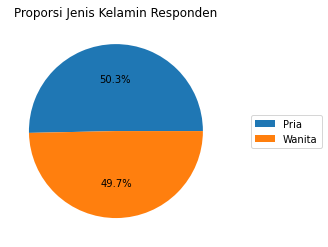

In [160]:
df1 = df_clean['Jenis Kelamin'].value_counts()
df1.plot.pie(title='Proporsi Jenis Kelamin Responden', labeldistance=None, autopct = '%1.1f%%', ylabel='')
plt.legend(bbox_to_anchor=(1,0.5), loc="center right", fontsize=10, bbox_transform=plt.gcf().transFigure)

plt.show()

### 2. Buat Tabel Frekuensi dan Proporsi Jenis Kelamin Responden

In [161]:
# Membuat dataframe baru yang memuat data frekuensi responden pria dan wanita
df2 = df1.copy()
df2 = df2.rename_axis('Jenis Kelamin').reset_index(name='Frekuensi')

# Membuat kolom baru, yaitu kolom Proporsi
df2['Proporsi'] = df2['Frekuensi'] / len(df_clean)

display(df2.style.hide_index())

Jenis Kelamin,Frekuensi,Proporsi
Pria,151,0.503333
Wanita,149,0.496667


### 3. Histogram Untuk Data Umur Responden

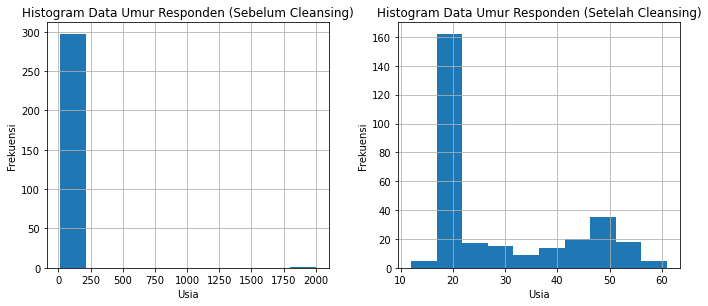

In [162]:
f, [ax1, ax2] = plt.subplots(1,2)
f.tight_layout()
f.set_figwidth(10)

# Prosedur untuk plotting histogram
def plotHistogram(ax, df):
    ax.hist(df['Usia'])
    ax.set(
        xlabel = 'Usia',
        ylabel = 'Frekuensi',
    )
    ax.grid()

plotHistogram(ax1, df) # Sebelum cleansing
ax1.set_title('Histogram Data Umur Responden (Sebelum Cleansing)')
plotHistogram(ax2, df_clean) # Setelah cleansing
ax2.set_title('Histogram Data Umur Responden (Setelah Cleansing)')

plt.show()


### 4. Boxplot Untuk Data Umur Responden

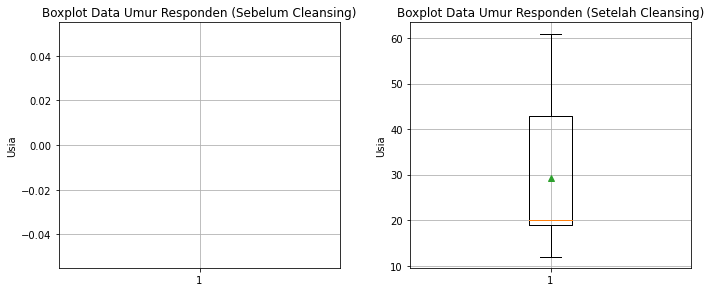

In [163]:
f, [ax1, ax2] = plt.subplots(1,2)
f.tight_layout()
f.set_figwidth(10)

# Prosedur untuk plotting boxplot
def plotBoxPlot(ax, df):
    ax.boxplot(df['Usia'], showmeans=True)
    ax.set_ylabel('Usia')
    ax.grid()

plotBoxPlot(ax1, df) # Sebelum cleansing
ax1.set_title('Boxplot Data Umur Responden (Sebelum Cleansing)')
plotBoxPlot(ax2, df_clean) # Setelah cleansing
ax2.set_title('Boxplot Data Umur Responden (Setelah Cleansing)')
plt.show()


### 5. Nilai Mean, Q1, Q2/Median, Q3, Min, Max Dari Data Umur Responden

In [164]:
print("Sebelum cleansing")
display(df['Usia'].describe())
print("Setelah cleansing")
display(df_clean['Usia'].describe())

Sebelum cleansing


count     298.000000
mean       35.768456
std       115.120330
min        12.000000
25%        19.000000
50%        20.000000
75%        43.000000
max      2003.000000
Name: Usia, dtype: float64

Setelah cleansing


count    300.000000
mean      29.180000
std       13.373998
min       12.000000
25%       19.000000
50%       20.000000
75%       43.000000
max       61.000000
Name: Usia, dtype: float64

### 6. Apakah Terdapat Outlier Pada Data Umur Responden? (Definisi outlier : < Q1 – 1.5 IQR atau > Q3 + 1.5 IQR; IQR = Q3 – Q1)

In [165]:
# Prosedur untuk menampilkan outlier
def showOutlier(df):
    iqr = df['Usia'].quantile(0.75) - df['Usia'].quantile(0.25) # Menghitung IQR
    q1 = df['Usia'].quantile(0.25) # Menghitung Q1
    q3 = df['Usia'].quantile(0.75) # Menghitung Q3

    # Dataframe berisi outlier pada data umur
    df6 = df.loc[(df['Usia'] < q1 - 1.5 * iqr) | (df['Usia'] > q3 + 1.5 * iqr)]

    if (len(df6) > 0):
        print("Ada, yaitu %s" % (df6["Usia"].to_string(index=False)))
    else:
        print("Tidak ada")

print("SEBELUM CLEANSING: ")
showOutlier(df)
print("SETELAH CLEANSING:")
showOutlier(df_clean)

SEBELUM CLEANSING: 
Ada, yaitu 2003.0
SETELAH CLEANSING:
Tidak ada


### 7. Pie Chart Perbedaan Frekuensi/Proporsi Profesi Responden

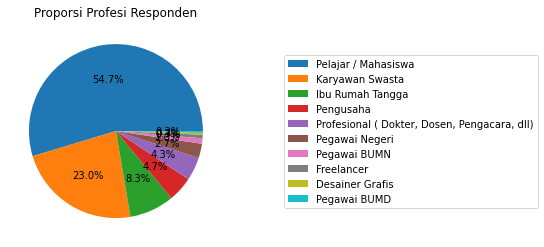

In [166]:
df7 = df_clean['Pekerjaan'].value_counts()
df7.plot.pie(title='Proporsi Profesi Responden', labeldistance=None, autopct = '%1.1f%%', ylabel='')
plt.legend(bbox_to_anchor=(1.5,0.5), loc="center right", fontsize=10, bbox_transform=plt.gcf().transFigure)

plt.show()

### 8. Tabel Frekuensi dan Proporsi Profesi Responden

In [167]:
# Membuat dataframe baru yang memuat data frekuensi pekerjaan responden 
df8 = df7.copy()
df8 = df8.rename_axis('Pekerjaan').reset_index(name='Frekuensi')

# Membuat kolom baru, yaitu kolom Proporsi
df8['Proporsi'] = df8['Frekuensi'] / len(df_clean)

display(df8.style.hide_index())

Pekerjaan,Frekuensi,Proporsi
Pelajar / Mahasiswa,164,0.546667
Karyawan Swasta,69,0.230000
Ibu Rumah Tangga,25,0.083333
Pengusaha,14,0.046667
"Profesional ( Dokter, Dosen, Pengacara, dll)",13,0.043333
Pegawai Negeri,8,0.026667
Pegawai BUMN,3,0.010000
Freelancer,2,0.006667
Desainer Grafis,1,0.003333
Pegawai BUMD,1,0.003333


### 9. Pie Chart Perbedaan Frekuensi/Proporsi Apakah Aktivitas Online Responden Meningkat Dalam 3 Bulan Terakhir

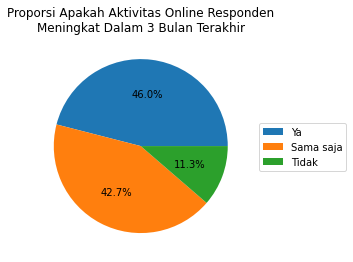

In [168]:
df9 = df_clean['Aktivitas Online Meningkat'].value_counts()
df9.plot.pie(title="\n".join(wrap('Proporsi Apakah Aktivitas Online Responden Meningkat Dalam 3 Bulan Terakhir', 50)), 
             labeldistance=None, 
             autopct = '%1.1f%%',
             ylabel='')
plt.legend(bbox_to_anchor=(1,0.5), 
           loc="center right",
           fontsize=10, 
           bbox_transform=plt.gcf().transFigure)

plt.show()

### 10. Tabel Frekuensi dan Proporsi Apakah Aktivitas Online Responden Meningkat Dalam 3 Bulan Terakhir

In [169]:
# Membuat dataframe baru yang memuat data frekuensi apakah aktivitas online responden meningkat dalam 3 bulan terakhir
df10 = df9.copy()
df10 = df10.rename_axis('Aktivitas Online Meningkat').reset_index(name='Frekuensi')

# Membuat kolom baru, yaitu kolom Proporsi
df10['Proporsi'] = df10['Frekuensi'] / len(df_clean)

display(df10.style.hide_index())

Aktivitas Online Meningkat,Frekuensi,Proporsi
Ya,138,0.460000
Sama saja,128,0.426667
Tidak,34,0.113333


### 11. Bar Chart Perbandingan Frekuensi/Proporsi Pengguna 7 Bank yang Ada di Kolom Bank_1 sampai bank_7

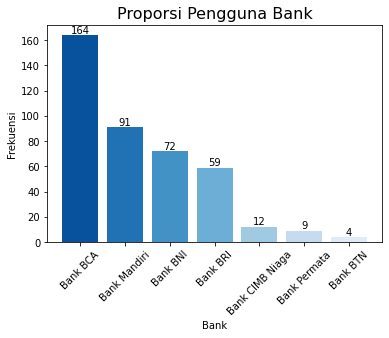

In [170]:
# Membuat dataframe berisi frekuensi dari masing-masing bank
df11 = df_clean.loc[:, 'bank_1':'bank_7'].count().rename_axis('Bank').reset_index(name='Frekuensi')

# Membuat tick labels untuk x axis
labels = []
for i in range (1, 8):
    labels.append(df_clean[f'bank_{i}'].value_counts().rename_axis('Bank').reset_index(name='Frekuensi')['Bank'][0])
df11['Bank'] = labels
df11 = df11.sort_values(by=['Frekuensi'], ascending=False).reset_index(drop=True)

fig, ax = plt.subplots()

bars = ax.bar(df11.set_index('Bank').index, df11.set_index('Bank')['Frekuensi'], color=palette(1, 7))
ax.set_ylabel('Frekuensi')
ax.set_xlabel('Bank')
ax.bar_label(bars)

plt.title('Proporsi Pengguna Bank', fontsize=16)
plt.xticks(rotation = 45)
plt.show()


### 12. Tabel Frekuensi dan Proporsi Pengguna 7 Bank yang Ada di Kolom bank_1 Sampai bank_7

In [171]:
df12 = df11.copy() # Sudah ada df11 yang merupakan tabel frekuensi, sehingga tinggal dicopy

# Membuat kolom baru, yaitu kolom Proporsi
df12['Proporsi'] = df12['Frekuensi'] / len(df_clean)

display(df12.style.hide_index())

Bank,Frekuensi,Proporsi
Bank BCA,164,0.546667
Bank Mandiri,91,0.303333
Bank BNI,72,0.240000
Bank BRI,59,0.196667
Bank CIMB Niaga,12,0.040000
Bank Permata,9,0.030000
Bank BTN,4,0.013333


### 13. Confidence Interval 95% Untuk Proporsi Pengguna Bank BCA

In [172]:
n = len(df_clean)
alpha = 1-0.95
pBCA = float(df12.loc[df12['Bank'] == 'Bank BCA']['Proporsi'].to_string(index=False))

# Menghitung error, lower bound, dan upper bound
## error = z_alpha/2 * sqrt(p(1-p)/n)
error =  norm.ppf(1-alpha/2) * math.sqrt(pBCA*(1-pBCA)/n)
lowerBound = pBCA - error
upperBound = pBCA + error

print(lowerBound, '< pBCA <', upperBound)

0.4903346900879819 < pBCA < 0.6029993099120181


### 14. Uji Hipotesis  
H0: p<sub>BCA</sub> = 0.5  
H1: p<sub>BCA</sub> ≠ 0.5  
α = 5%

In [173]:
# Uji hipotesis 2 sisi
## Critical region:
## Z > Z(a/2) atau Z < -Z(a/2)

alpha = 0.05
p0 = 0.5

# Menghitung z_uji
# z_uji = (n*p - n*p0)/sqrt(n*p0*(1-p0))
z_uji = (n*pBCA - n*p0)/math.sqrt(n*p0*(1-p0)) 

print("Critical region:")
print("Z >", norm.ppf(1-alpha))
print("Z <", -norm.ppf(1-alpha))

print("Karena z_uji (= {})".format(z_uji), end=' ')
if norm.ppf(1-alpha/2) < z_uji or -norm.ppf(1-alpha/2) > z_uji:
    print("berada di critical region, maka hipotesis ditolak dengan signifikansi 5%")
else:
    print("tidak berada di critical region, maka hipotesis gagal ditolak dengan signifikansi 5%")

Critical region:
Z > 1.6448536269514722
Z < -1.6448536269514722
Karena z_uji (= 1.616592300736336) tidak berada di critical region, maka hipotesis gagal ditolak dengan signifikansi 5%


### 15. Bar Chart Perbandingan Frekuensi/Proporsi Preferensi Channel yang Dipilih Responden Untuk Melakukan Transaksi Antar Bank

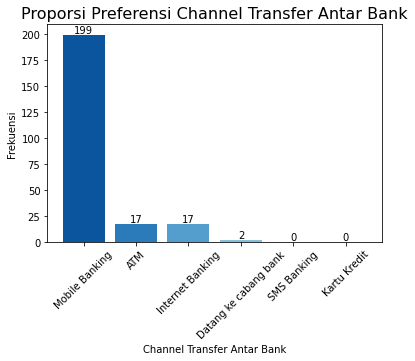

In [174]:
# Membuat dataframe berisi frekuensi dari masing-masing bank
df15 = df_clean['19. Manakah channel/ layanan yang lebih Anda sukai ketika Anda akan menggunakan fitur-fitur layanan perbankan berikut? [Transfer antar bank]'].value_counts().rename_axis('Channel Transfer Antar Bank').reset_index(name='Frekuensi')

df15.loc[len(df15)] = 'SMS Banking', 0
df15.loc[len(df15)] = 'Kartu Kredit', 0

fig, ax = plt.subplots()

bars = ax.bar(df15.set_index('Channel Transfer Antar Bank').index, df15.set_index('Channel Transfer Antar Bank')['Frekuensi'], color=palette(1, 6))
ax.set_ylabel('Frekuensi')
ax.set_xlabel('Channel Transfer Antar Bank')
ax.bar_label(bars)

plt.title('Proporsi Preferensi Channel Transfer Antar Bank', fontsize=16)
plt.xticks(rotation = 45)
plt.show()


### 16. Tabel Frekuensi dan Proporsi Preferensi Channel yang Dipilih Responden Untuk Melakukan Transaksi Antar Bank

In [175]:
df16 = df15.copy() # Sudah ada df15 yang merupakan tabel frekuensi, sehingga tinggal dicopy

# Membuat kolom baru, yaitu kolom Proporsi
df16['Proporsi'] = df16['Frekuensi'] / len(df_clean)

display(df16.style.hide_index())

Channel Transfer Antar Bank,Frekuensi,Proporsi
Mobile Banking,199,0.663333
ATM,17,0.056667
Internet Banking,17,0.056667
Datang ke cabang bank,2,0.006667
SMS Banking,0,0.000000
Kartu Kredit,0,0.000000


### 17. Bar Chart Perbandingan Frekuensi/Proporsi Pengguna 7 E-Money yang Ada di Kolom emoney_pilihan_1 Sampai emoney_pilihan_7

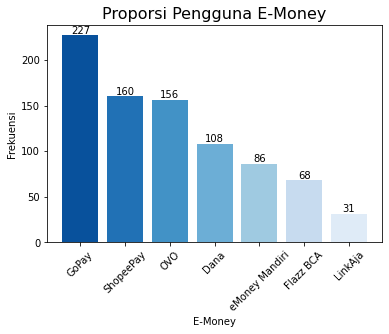

In [176]:
# Membuat dataframe berisi frekuensi dari masing-masing e-money
df17 = df_clean.loc[:, 'emoney_pilihan_1':'emoney_pilihan_7'].count().rename_axis('E-Money').reset_index(name='Frekuensi')

# Membuat tick labels untuk x axis
labels = []
for i in range (1, 8):
    labels.append(df_clean[f'emoney_pilihan_{i}'].value_counts().rename_axis('E-Money').reset_index(name='Frekuensi')['E-Money'][0])
df17['E-Money'] = labels
df17 = df17.sort_values(by=['Frekuensi'], ascending=False).reset_index(drop=True)

fig, ax = plt.subplots()

bars = ax.bar(df17.set_index('E-Money').index, df17.set_index('E-Money')['Frekuensi'], color=palette(1, 7))
ax.set_ylabel('Frekuensi')
ax.set_xlabel('E-Money')
ax.bar_label(bars)

plt.title('Proporsi Pengguna E-Money', fontsize=16)
plt.xticks(rotation = 45)
plt.show()


### 18. Tabel Frekuensi dan Proporsi Pengguna 7 E-Money yang Ada di Kolom emoney_pilihan_1 Sampai emoney_pilihan_7

In [177]:
df18 = df17.copy() # Sudah ada df17 yang merupakan tabel frekuensi, sehingga tinggal dicopy

# Membuat kolom baru, yaitu kolom Proporsi
df18['Proporsi'] = df18['Frekuensi'] / len(df_clean)

display(df18.style.hide_index())

E-Money,Frekuensi,Proporsi
GoPay,227,0.756667
ShopeePay,160,0.533333
OVO,156,0.520000
Dana,108,0.360000
eMoney Mandiri,86,0.286667
Flazz BCA,68,0.226667
LinkAja,31,0.103333


### 19. Confidence Interval 95% Untuk Selisih Proporsi Pengguna GoPay dan OVO

In [178]:
n = len(df_clean)
alpha = 1-0.95
pGoPay = float(df18.loc[df18['E-Money'] == 'GoPay']['Proporsi'].to_string(index=False))
pOVO = float(df18.loc[df18['E-Money'] == 'OVO']['Proporsi'].to_string(index=False))

# Menghitung error, lower bound, dan upper bound
## error = z_alpha/2 * sqrt(p(1-p)/n)
error =  norm.ppf(1-alpha/2) * math.sqrt((pGoPay*(1-pGoPay)/n) + (pOVO*(1-pOVO)/n))
lowerBound = pGoPay - pOVO - error
upperBound = pGoPay - pOVO + error

print(lowerBound, '< pGoPay - pOVO <', upperBound)


0.1621435048464602 < pGoPay - pOVO < 0.3111904951535397


### 20. Uji Hipotesis  
H0: p<sub>GoPay</sub> = p<sub>OVO</sub>  
H1: p<sub>GoPay</sub> > p<sub>OVO</sub>  
α = 5%

In [179]:
alpha = 0.05
p0 = 0.5
xGopay = int(df18.loc[df18['E-Money'] == 'GoPay']['Frekuensi'].to_string(index=False))
xOVO = int(df18.loc[df18['E-Money'] == 'OVO']['Frekuensi'].to_string(index=False))

pGabungan = (xGopay + xOVO)/(2*n)

# Menghitung z_uji
# Rumus: z_uji = (p1 - p2)/sqrt(pGabungan*(1-pGabungan)*(1/n1 + 1/n2))
z_uji = (pGoPay - pOVO)/math.sqrt(pGabungan*(1-pGabungan)*(1/n + 1/n)) 

print("Critical region:")
print("Z >", norm.ppf(1-alpha))
print("Z <", -norm.ppf(1-alpha))

print("Karena z_uji (= {})".format(z_uji), end=' ')
if norm.ppf(1-alpha) < z_uji or -norm.ppf(1-alpha) > z_uji:
    print("berada di critical region, maka hipotesis ditolak dengan signifikansi 5%")
else:
    print("tidak berada di critical region, maka hipotesis gagal ditolak dengan signifikansi 5%")

Critical region:
Z > 1.6448536269514722
Z < -1.6448536269514722
Karena z_uji (= 6.0326111391074555) berada di critical region, maka hipotesis ditolak dengan signifikansi 5%


### 21. Pie Chart Perbandingan Frekuensi/Proporsi Nominal yang Biasa Dipakai Untuk Top-up E-Money

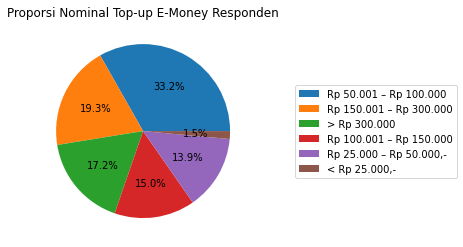

In [180]:
df21 = df_clean['39. Berapa biasanya nominal Anda melakukan top up/ isi ulang?'].value_counts()

df21.plot.pie(title='Proporsi Nominal Top-up E-Money Responden', labeldistance=None, autopct = '%1.1f%%', ylabel='')
plt.legend(bbox_to_anchor=(1.25,0.5), loc="center right", fontsize=10, bbox_transform=plt.gcf().transFigure)

plt.show()

### 22. Tabel Frekuensi dan Proporsi Nominal yang Biasa Dipakai Untuk Top-up E-Money

In [181]:
# Membuat dataframe baru yang memuat data frekuensi nominal yang biasa dipakai untuk top-up e-money
df22 = df21.copy()
df22 = df22.rename_axis('Nominal Top-up').reset_index(name='Frekuensi')

# Membuat kolom baru, yaitu kolom Proporsi
df22['Proporsi'] = df22['Frekuensi'] / len(df_clean.loc[pd.notnull(df_clean['39. Berapa biasanya nominal Anda melakukan top up/ isi ulang?'])])

display(df22.style.hide_index())

Nominal Top-up,Frekuensi,Proporsi
Rp 50.001 – Rp 100.000,91,0.332117
Rp 150.001 – Rp 300.000,53,0.193431
> Rp 300.000,47,0.171533
Rp 100.001 – Rp 150.000,41,0.149635
"Rp 25.000 – Rp 50.000,-",38,0.138686
"< Rp 25.000,-",4,0.014599


### 23. Bar Chart Perbandingan Frekuensi/Proporsi Pengguna 7 E-Commerce yang Ada di Kolom ecommerce_pilihan_1 Sampai ecommerce_pilihan_7

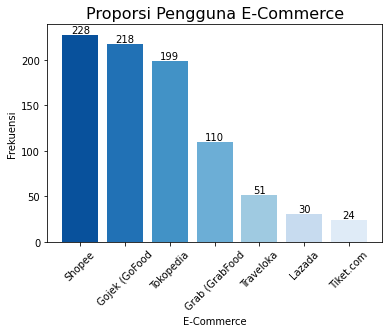

In [182]:
# Membuat dataframe berisi frekuensi dari masing-masing e-commerce
df23 = df_clean.loc[:, 'ecommerce_pilihan_1':'ecommerce_pilihan_7'].count().rename_axis('E-Commerce').reset_index(name='Frekuensi')

# Membuat tick labels untuk x axis
labels = []
for i in range (1, 8):
    labels.append(df_clean[f'ecommerce_pilihan_{i}'].value_counts().rename_axis('E-Commerce').reset_index(name='Frekuensi')['E-Commerce'][0])
df23['E-Commerce'] = labels
df23 = df23.sort_values(by=['Frekuensi'], ascending=False).reset_index(drop=True)

fig, ax = plt.subplots()

bars = ax.bar(df23.set_index('E-Commerce').index, df23.set_index('E-Commerce')['Frekuensi'], color=palette(1, 7))
ax.set_ylabel('Frekuensi')
ax.set_xlabel('E-Commerce')
ax.bar_label(bars)

plt.title('Proporsi Pengguna E-Commerce', fontsize=16)
plt.xticks(rotation = 45)
plt.show()


### 24. Tabel Frekuensi dan Proporsi Pengguna 7 E-Commerce yang Ada di Kolom ecommerce_pilihan_1 Sampai ecommerce_pilihan_7

In [183]:
df24 = df23.copy() # Sudah ada df23 yang merupakan tabel frekuensi, sehingga tinggal dicopy

# Membuat kolom baru, yaitu kolom Proporsi
df24['Proporsi'] = df24['Frekuensi'] / len(df_clean)

display(df24.style.hide_index())

E-Commerce,Frekuensi,Proporsi
Shopee,228,0.760000
Gojek (GoFood,218,0.726667
Tokopedia,199,0.663333
Grab (GrabFood,110,0.366667
Traveloka,51,0.170000
Lazada,30,0.100000
Tiket.com,24,0.080000


### 25. Pie Chart Perbandingan Frekuensi/Proporsi Kecenderungan Metode Membeli Handphone Responden

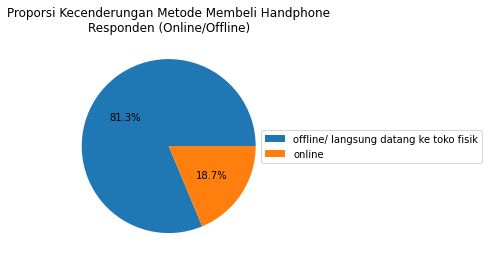

In [184]:
df25 = df_clean['47. Bagaimana kecenderungan Anda jika akan berbelanja hal-hal berikut? [handphone]'].value_counts()
df25.plot.pie(title='\n'.join(wrap('Proporsi Kecenderungan Metode Membeli Handphone Responden (Online/Offline)', 50)), 
              labeldistance=None,
              autopct = '%1.1f%%', 
              ylabel='')
plt.legend(bbox_to_anchor=(1.25,0.5), loc="center right", fontsize=10, bbox_transform=plt.gcf().transFigure)

plt.show()

### 26. Tabel Frekuensi dan Proporsi Kecenderungan Metode Membeli Handphone Responden

In [185]:
# Membuat dataframe baru yang memuat data frekuensi kecenderungan metode membeli handphone 
df26 = df25.copy()
df26 = df26.rename_axis('Kecenderungan Metode Membeli Handphone').reset_index(name='Frekuensi')

# Membuat kolom baru, yaitu kolom Proporsi
df26['Proporsi'] = df26['Frekuensi'] / len(df_clean.loc[pd.notnull(df_clean['47. Bagaimana kecenderungan Anda jika akan berbelanja hal-hal berikut? [handphone]'])])

display(df26.style.hide_index())

Kecenderungan Metode Membeli Handphone,Frekuensi,Proporsi
offline/ langsung datang ke toko fisik,213,0.812977
online,49,0.187023


### 27. Pie Chart Perbandingan Frekuensi/Proporsi Tempat yang Paling Sering Digunakan Untuk Layanan Food Delivery

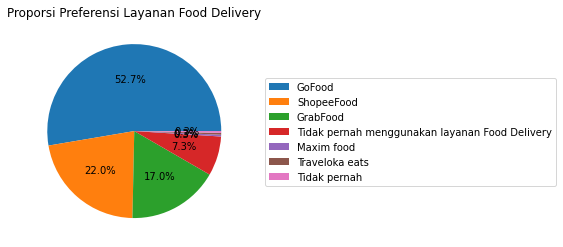

In [186]:
df27 = df_clean['50. Apakah Anda pernah menggunakan layanan Food Delivery (pembelian makanan/ minuman secara online )? Jika Pernah, mohon sebutkan layanan yang PALING sering Anda gunakan?'].value_counts()
df27.plot.pie(title='Proporsi Preferensi Layanan Food Delivery', labeldistance=None, autopct = '%1.1f%%', ylabel='')
plt.legend(bbox_to_anchor=(1.5,0.5), loc="center right", fontsize=10, bbox_transform=plt.gcf().transFigure)

plt.show()

### 28. Tabel Frekuensi dan Proporsi Tempat yang Paling Sering Digunakan Untuk Layanan Food Delivery

In [187]:
# Membuat dataframe baru yang memuat data frekuensi tempat yang paling sering digunakan untuk layanan food delivery
df28 = df27.copy()
df28 = df28.rename_axis('Proporsi Preferensi Layanan Food Delivery').reset_index(name='Frekuensi')

# Membuat kolom baru, yaitu kolom Proporsi
df28['Proporsi'] = df28['Frekuensi'] / len(df_clean)

display(df28.style.hide_index())

Proporsi Preferensi Layanan Food Delivery,Frekuensi,Proporsi
GoFood,158,0.526667
ShopeeFood,66,0.220000
GrabFood,51,0.170000
Tidak pernah menggunakan layanan Food Delivery,22,0.073333
Maxim food,1,0.003333
Traveloka eats,1,0.003333
Tidak pernah,1,0.003333


### 29. Lakukan One Way ANOVA Test berikut:
H0: Mean umur pengguna gofood = mean umur pengguna grabfood = mean umur pengguna shopeefood  
H1: Setidaknya ada dua grup yang memiliki mean umur yang berbeda  
α = 5%

In [188]:
df30 = df_clean.copy()
df30.rename(columns={"50. Apakah Anda pernah menggunakan layanan Food Delivery (pembelian makanan/ minuman secara online )? Jika Pernah, mohon sebutkan layanan yang PALING sering Anda gunakan?": "Food_Delivery"}, inplace=True)
df30 = df30.loc[(df30['Food_Delivery'] == "GoFood") | (df30['Food_Delivery'] == 'GrabFood') | (df30['Food_Delivery'] == "ShopeeFood")]

# Membuat anova table
model = ols('Usia ~ C(Food_Delivery)', data=df30).fit()
anova_model = sm.stats.anova_lm(model, typ=1)
print("Tabel anova:")
display(anova_model)

Tabel anova:


,df,sum_sq,mean_sq,F,PR(>F)
C(Food_Delivery),2.0,2272.357488,1136.178744,7.116785,0.000971
Residual,272.0,43424.187967,159.647750,NaN,NaN


In [189]:
# Mencari f_alpha
alpha = 0.05
f_alpha = st.f.ppf(1-alpha, dfn=anova_model['df'][0], dfd=anova_model['df'][1])
print("Critical region:")
print("f >", f_alpha)

print("Karena f_uji (= {})".format(anova_model['F'][0]), end=' ')
if anova_model['F'][0] > f_alpha:
    print("berada di critical region, maka hipotesis ditolak")
else:
    print("tidak berada di critical region, maka hipotesis gagal ditolak")

Critical region:
f > 3.0289700337744754
Karena f_uji (= 7.116785202100403) berada di critical region, maka hipotesis ditolak


### 30. Insights/Pelajaran dari Hasil Pengolahan Data Responden

In [190]:
print(f"""
Berdasarkan pengolahan data responden dengan sampel sebanyak {len(df_clean)} orang, didapatkan insights:
1. Setelah melakukan cleaning data, terdapat {df2['Frekuensi'][0]} responden pria, {df2['Frekuensi'][1]} responden wanita
2. Rata-rata responden berumur {int(df_clean['Usia'].mean())} tahun, dengan responden termuda berusia {int(df_clean['Usia'].min())} tahun dan responden tertua berusia {int(df_clean['Usia'].max())} tahun
3. Profesi terbanyak dari sampel responden ini ialah {df8['Pekerjaan'][0]} sebanyak {df8['Frekuensi'][0]} orang
4. Hampir setengah dari responden ({df10['Proporsi'][0] * 100}%) merasa aktivitas onlinenya meningkat dalam 3 bulan terakhir
5. {df12['Bank'][0]} paling banyak digunakan oleh responden, yaitu sebanyak {df12['Frekuensi'][0]} responden
6. Setelah melakukan uji hipotesis, didapatkan bahwasanya proporsi pengguna bank BCA tidak sama dengan 0.5
7. {df16['Channel Transfer Antar Bank'][0]} paling banyak digunakan oleh responden untuk melakukan transfer antar bank
8. {df18['E-Money'][0]} paling banyak digunakan oleh responden untuk pembayaran emoney
9. Setelah melakukan uji hipotesis, didapatkan bahwasanya proporsi pengguna GoPay lebih besar dari proporsi pengguna OVO
10. Sebagian besar responden ({df22['Proporsi'][0] * 100:.2f}% dari {df22['Frekuensi'].sum()} responden valid) memilih Top Up E-Money sebesar {df22['Nominal Top-up'][0]}
11. {df24['E-Commerce'][0]} paling banyak digunakan oleh responden ({df24['Frekuensi'][0]} orang) untuk ecommerce
12. Sebanyak {df26['Proporsi'][0] * 100:.2f}% dari {df26['Frekuensi'][0]} responden valid lebih memilih membeli handphone secara {df26['Kecenderungan Metode Membeli Handphone'][0]} dibandingkan membelinya secara {df26['Kecenderungan Metode Membeli Handphone'][1]}
13. {df28['Proporsi Preferensi Layanan Food Delivery'][0]} paling banyak digunakan oleh responden untuk melakukan pemesanan makanan online
14. Setelah melakukan One Way ANOVA, didapatkan bahwasanya setidaknya ada dua grup pengguna GoFood, GrabFood, dan ShopeeFood yang memiliki mean umur berbeda
""")


Berdasarkan pengolahan data responden dengan sampel sebanyak 300 orang, didapatkan insights:
1. Setelah melakukan cleaning data, terdapat 151 responden pria, 149 responden wanita
2. Rata-rata responden berumur 29 tahun, dengan responden termuda berusia 12 tahun dan responden tertua berusia 61 tahun
3. Profesi terbanyak dari sampel responden ini ialah Pelajar / Mahasiswa sebanyak 164 orang
4. Hampir setengah dari responden (46.0%) merasa aktivitas onlinenya meningkat dalam 3 bulan terakhir
5. Bank BCA paling banyak digunakan oleh responden, yaitu sebanyak 164 responden
6. Setelah melakukan uji hipotesis, didapatkan bahwasanya proporsi pengguna bank BCA tidak sama dengan 0.5
7. Mobile Banking paling banyak digunakan oleh responden untuk melakukan transfer antar bank
8. GoPay paling banyak digunakan oleh responden untuk pembayaran emoney
9. Setelah melakukan uji hipotesis, didapatkan bahwasanya proporsi pengguna GoPay lebih besar dari proporsi pengguna OVO
10. Sebagian besar responden (3